# 毕业论文`GRAD`
## 计算贡献值

---
*@author: Evan*\
*@date: 2023-12-03*

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from namelist import *

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

* 观测值的low与high之差包含了MET与EMIS的作用；
* 模拟的low和试验之差，代表的MET的作用
* 模拟的high和试验之差，代表了EMIS的作用

In [2]:
df = pd.read_excel(datadir + 'Contribution/contribution_hours.xlsx',index_col=0)

In [3]:
# calculate MDA8
df_mda8 = df.rolling(8).mean().resample('D').max()
df_mean = df_mda8.mean(axis=0)
df_mean

sim_2014    144.631615
obs_2014    110.965211
sim_2015    158.185828
obs_2015    112.832658
sim_2016    156.320787
obs_2016    107.908635
sim_2019    154.018103
obs_2019    154.611629
sim_2021    157.146947
obs_2021    124.396497
sim_2022    166.620089
obs_2022    161.912303
sen_2019    160.503316
sen_2021    161.122983
sen_2022    173.392895
dtype: float64

In [57]:
obs_low_list  = ['obs_2014','obs_2015','obs_2016']
obs_high_list = ['obs_2019','obs_2021','obs_2022']
sim_low_list  = ['sim_2014','sim_2015','sim_2016']
sim_high_list = ['sim_2019','sim_2021','sim_2022']
sen_high_list = ['sen_2019','sen_2021','sen_2022']

obs_low  = df_mean[obs_low_list].mean()
obs_high = df_mean[obs_high_list].mean()
sim_low  = df_mean[sim_low_list].mean()
sim_high = df_mean[sim_high_list].mean()
sen_high = df_mean[sen_high_list].mean()

print('obs_low  = ',obs_low,
      '\nobs_high = ',obs_high,
      '\nsim_low  = ',sim_low,
      '\nsim_high = ',sim_high,
      '\nsen_high = ',sen_high)

obs_low  =  110.5688346859074 
obs_high =  146.9734766306779 
sim_low  =  153.04607637193467 
sim_high =  159.2617132610745 
sen_high =  165.0063980102539


In [53]:
delta_obs           = obs_high - obs_low
delta_low_with_sen  = sen_high - sim_low
delta_high_with_sen = sim_high - sen_high

print('ΔMET + ΔEMIS = {:.2f}'.format(delta_obs),
      '\nΔMET = {:.2f}'.format(delta_low_with_sen),', {:.2f}%'.format(delta_low_with_sen/delta_obs*100),
      '\nΔEMIS = {:.2f}'.format(delta_high_with_sen),', {:.2f}%'.format(delta_high_with_sen/delta_obs*100))

ΔMET + ΔEMIS = 36.40 
ΔMET = 11.96 , 32.85% 
ΔEMIS = -5.74 , -15.78%


直接对原数据做计算结果太差，要做线性回归

## 绘制散点图

In [30]:
# 定义时间范围
time_ranges = {
    'day': ('8:00', '17:00'),
    'night': ('18:00', '7:00')
    }

# 定义数据列表
data_lists = {
    "obs_low": obs_low_list,
    "obs_high": obs_high_list,
    "sim_low": sim_low_list,
    "sim_high": sim_high_list,
    "sen_high": sen_high_list,
}

In [ ]:
results = {}

for data_type, columns in data_lists.items():
    for time_type, time_range in time_ranges.items():
        key = f"{data_type}_{time_type}"
        results[key] = df[columns].mean(axis=1).between_time(time_range[0], time_range[1])

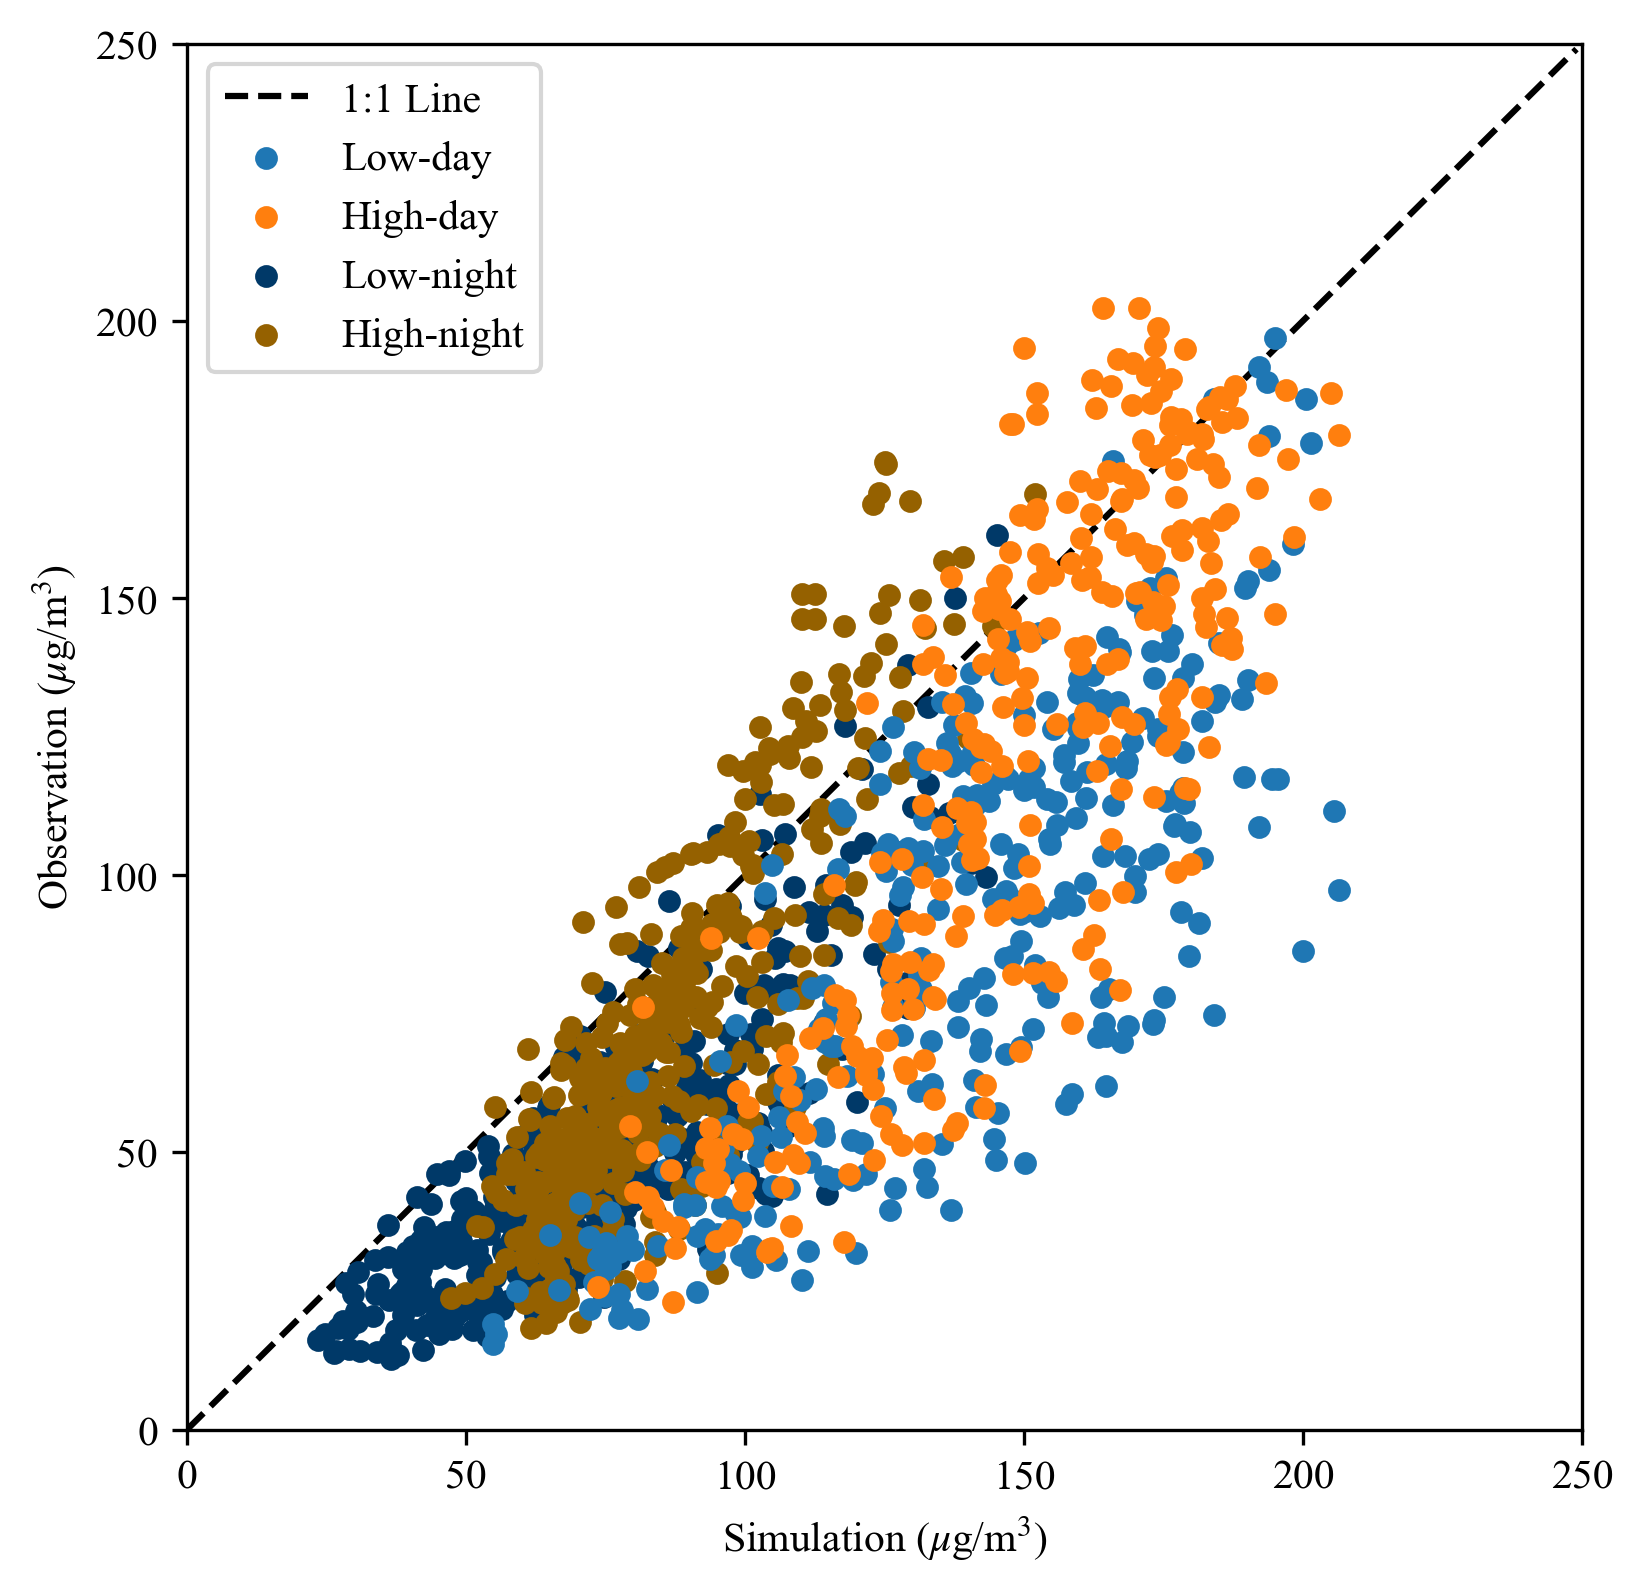

In [25]:
fig = plt.figure(figsize=(6, 6),dpi=300)
ax = fig.add_subplot(111)
ax.plot(np.arange(0,250),np.arange(0,250),'k--',zorder=0,label='1:1 Line')
ax.scatter(results['sim_low_day'].values, results['obs_low_day'].values,label='Low-day',color='tab:blue',s=20, marker='o',)
ax.scatter(results['sim_high_day'].values, results['obs_high_day'].values,label='High-day',color='tab:orange',s=20, marker='o',)
ax.scatter(results['sim_low_night'].values, results['obs_low_night'].values,label='Low-night',color='#003968',s=20, marker='o',zorder=0)
ax.scatter(results['sim_high_night'].values, results['obs_high_night'].values,label='High-night',color='#956100',s=20, marker='o',zorder=0)
ax.set_xlim(0,250)
ax.set_ylim(0,250)
ax.set_xlabel('Simulation ($\mu$g/m$^3$)')
ax.set_ylabel('Observation ($\mu$g/m$^3$)')
ax.legend()
plt.show()

发现日间夜间均偏高，没有必要分两段时间做回归\
同时发现low年份的模拟偏高更严重，因此应该分low与high做两段回归，或者以high为基准做回归

In [31]:
results = {}

# 遍历数据列表和时间范围
for data_type, columns in data_lists.items():
    results[data_type] = df[columns].mean(axis=1)

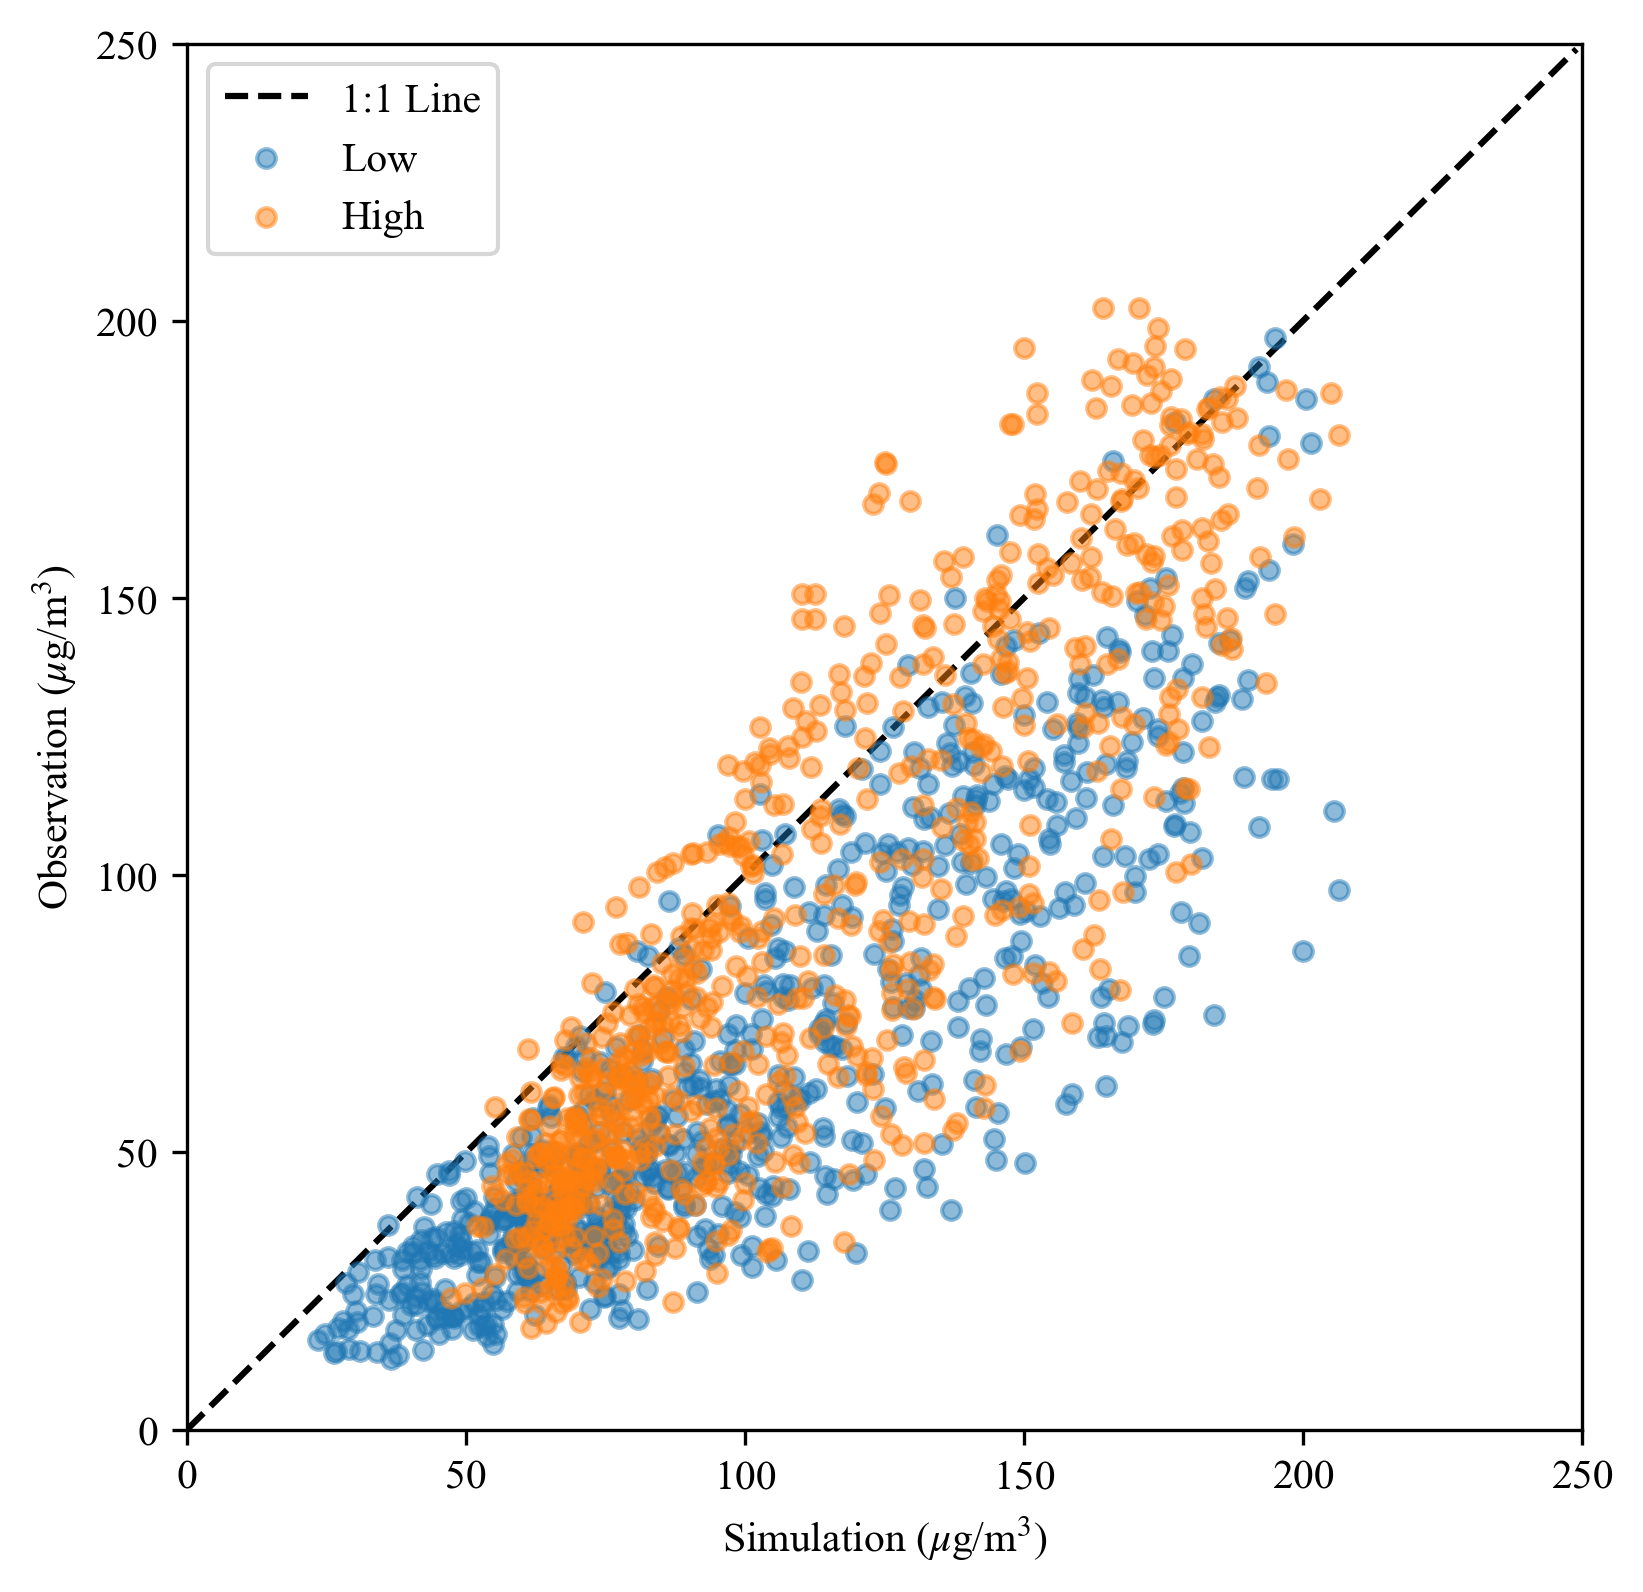

In [92]:
fig = plt.figure(figsize=(6, 6),dpi=300)
ax = fig.add_subplot(111)
ax.plot(np.arange(0,250),np.arange(0,250),'k--',zorder=0,label='1:1 Line')
ax.scatter(results['sim_low'].values, results['obs_low'].values,label='Low',color='tab:blue',s=20, marker='o',alpha=0.5)
ax.scatter(results['sim_high'].values, results['obs_high'].values,label='High',color='tab:orange',s=20, marker='o',alpha=0.5)
ax.set_xlim(0,250)
ax.set_ylim(0,250)
ax.set_xlabel('Simulation ($\mu$g/m$^3$)')
ax.set_ylabel('Observation ($\mu$g/m$^3$)')
ax.legend()
plt.show()

In [49]:
slope_high, intercept_high, r_value_high, p_value_high, std_err_high = stats.linregress(results['sim_high'],results['obs_high'])
slope_low, intercept_low, r_value_low, p_value_low, std_err_low = stats.linregress(results['sim_low'],results['obs_low'])

lr_data = {
    'high': [slope_high, intercept_high, r_value_high, p_value_high, std_err_high],
    'low': [slope_low, intercept_low, r_value_low, p_value_low, std_err_low]
}

lr = pd.DataFrame(lr_data, index=['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
lr

,high,low
slope,1.014910e+00,7.354822e-01
intercept,-2.212587e+01,-7.947762e+00
r_value,8.509679e-01,8.528244e-01
p_value,5.587493e-203,8.874910e-205
std_err,2.337715e-02,1.680681e-02


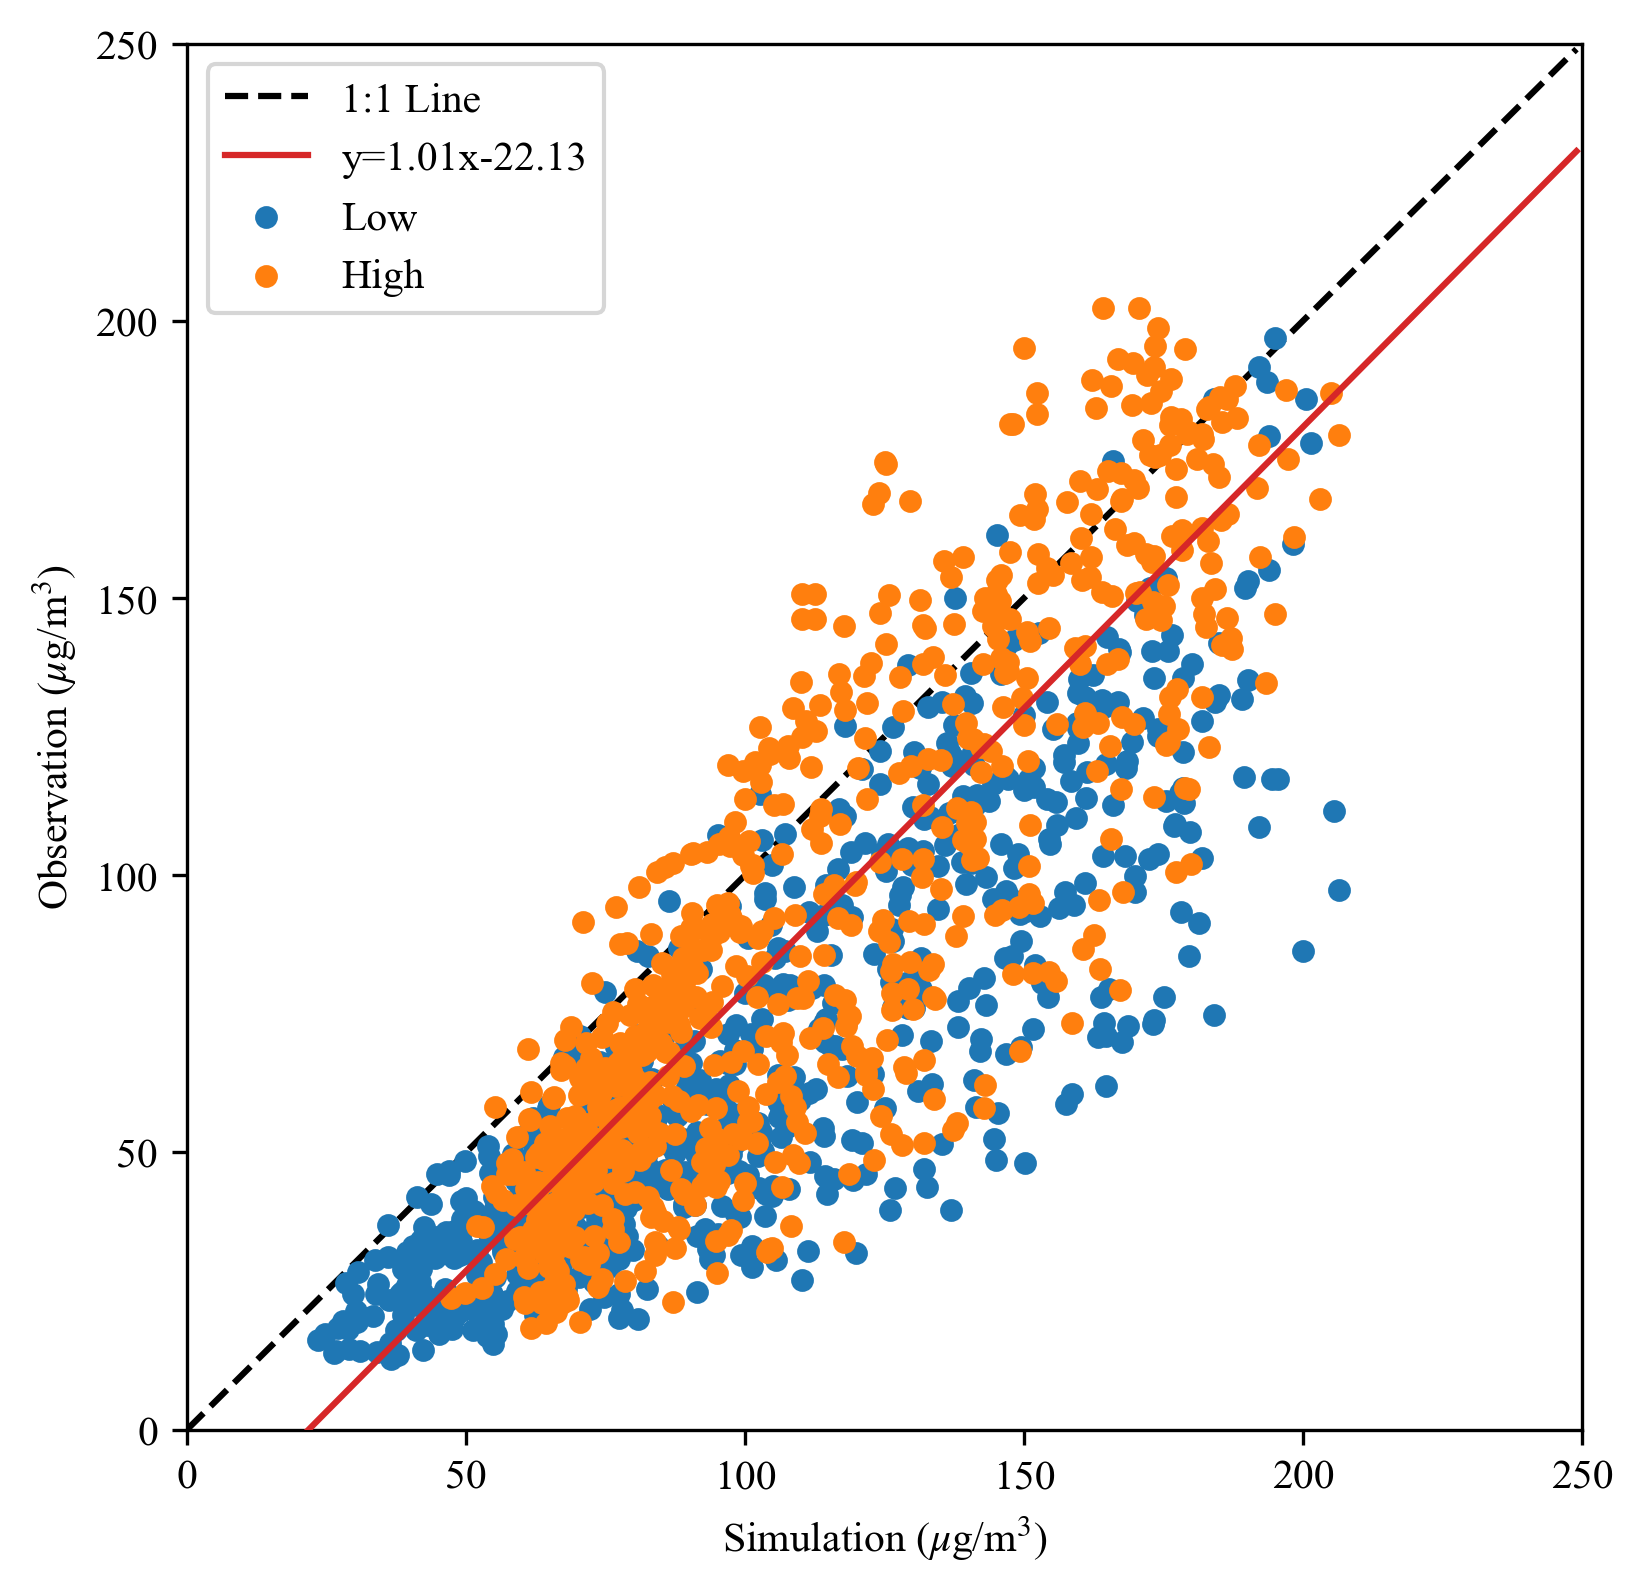

In [91]:
fig = plt.figure(figsize=(6, 6),dpi=300)
ax = fig.add_subplot(111)
ax.plot(np.arange(0,250),np.arange(0,250),'k--',zorder=0,label='1:1 Line')
slope = lr['high']['slope']
intercept = lr['high']['intercept']
ax.plot(np.arange(0,250),slope*np.arange(0,250)+intercept,color='tab:red',zorder=4,label=f'y={slope:.2f}x{intercept:.2f}')
ax.scatter(results['sim_low'].values, results['obs_low'].values,label='Low',color='tab:blue',s=20, marker='o',)
ax.scatter(results['sim_high'].values, results['obs_high'].values,label='High',color='tab:orange',s=20, marker='o',)
ax.set_xlim(0,250)
ax.set_ylim(0,250)
ax.set_xlabel('Simulation ($\mu$g/m$^3$)')
ax.set_ylabel('Observation ($\mu$g/m$^3$)')
ax.legend()
plt.show()

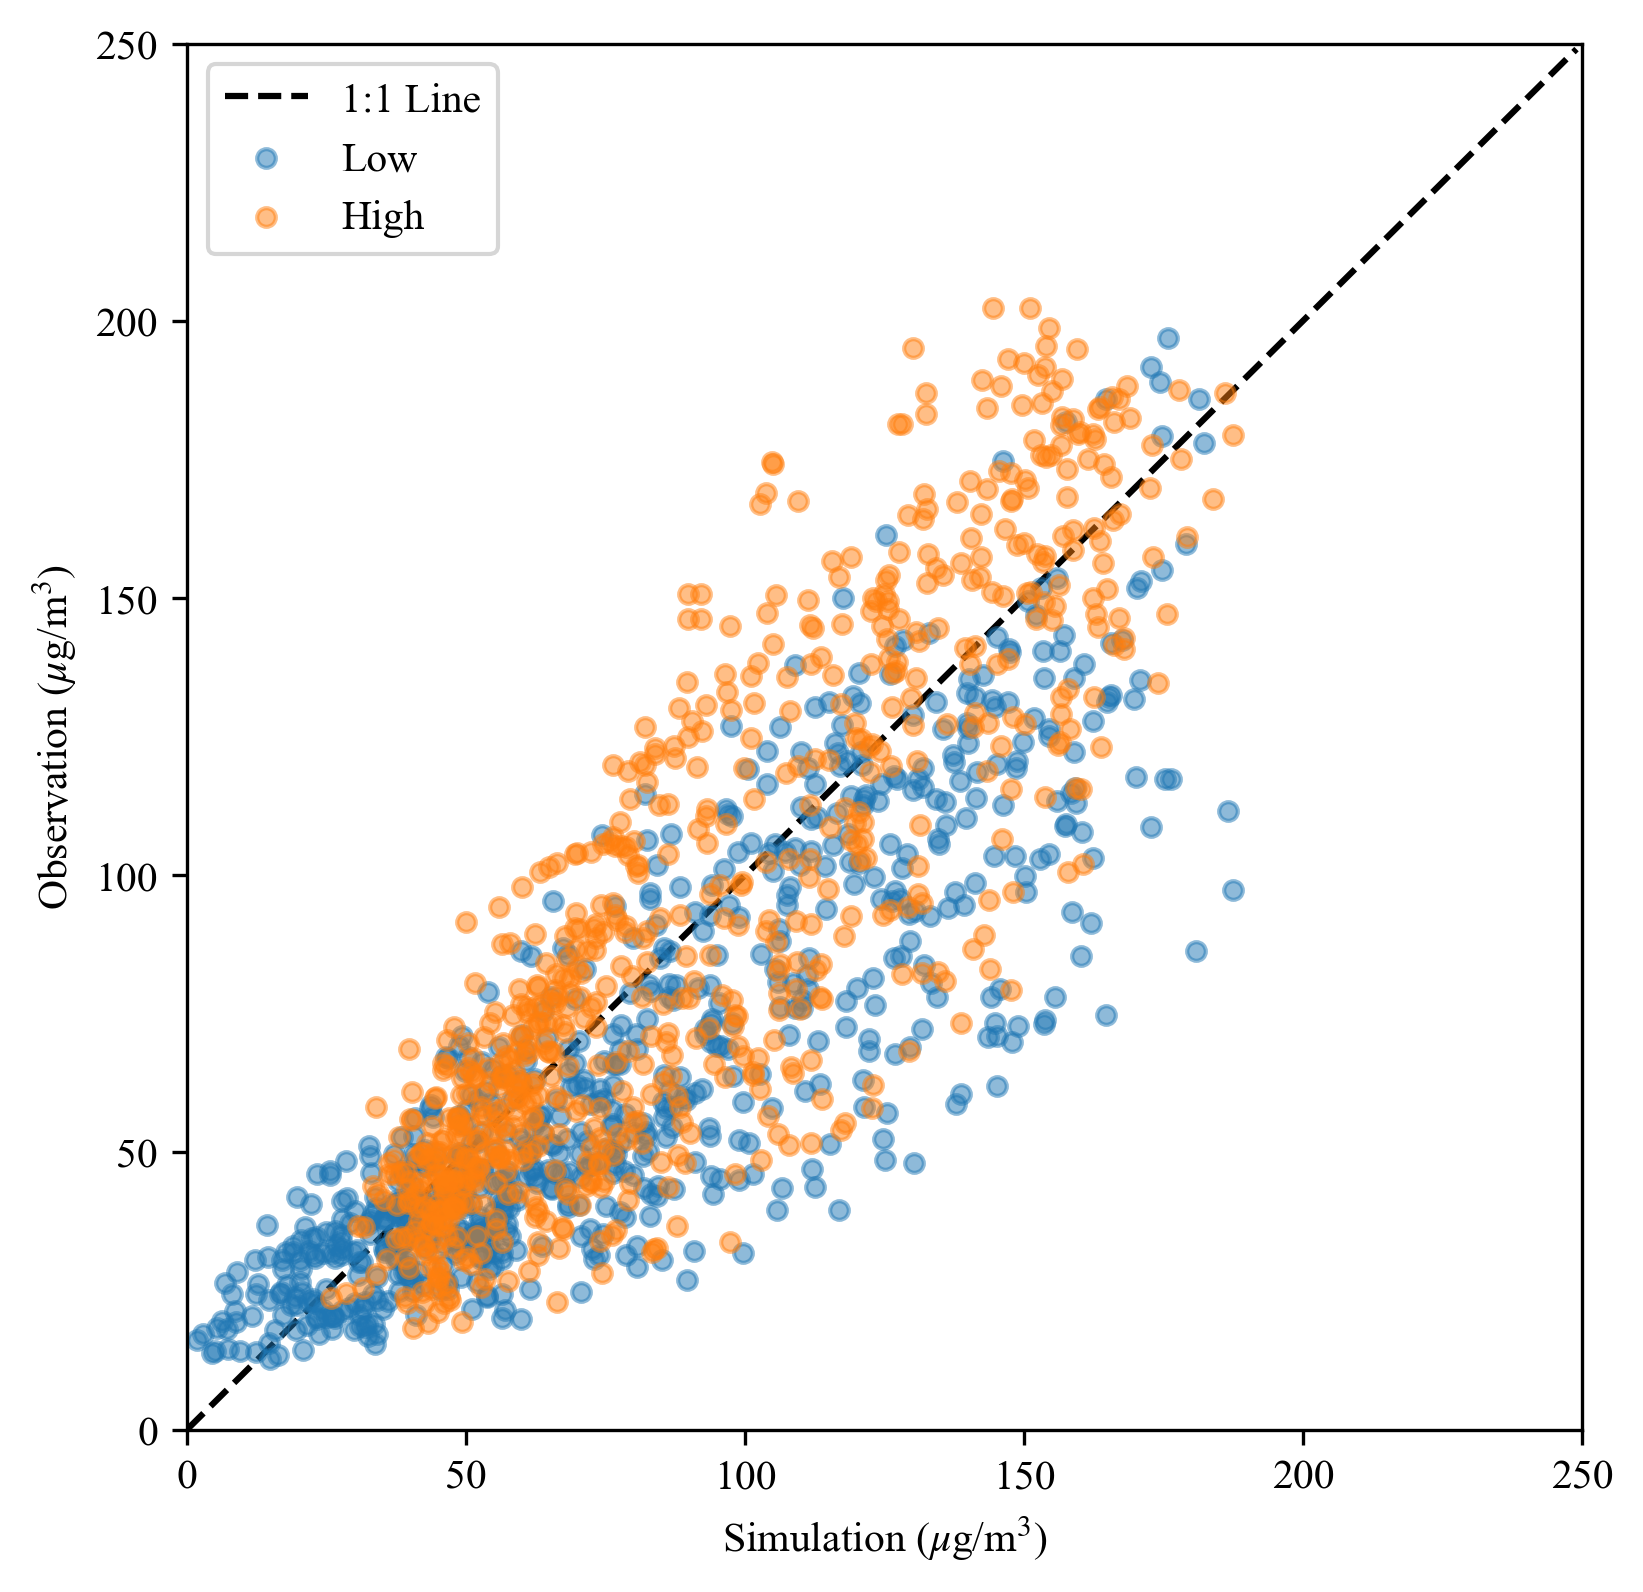

In [87]:
slope = lr['high']['slope']
intercept = lr['high']['intercept']

fig = plt.figure(figsize=(6, 6),dpi=300)
ax = fig.add_subplot(111)
ax.plot(np.arange(0,250),np.arange(0,250),'k--',zorder=0,label='1:1 Line')
ax.scatter(slope*results['sim_low'].values+intercept, results['obs_low'].values,label='Low',color='tab:blue',s=20, marker='o',alpha=0.5)
ax.scatter(slope*results['sim_high'].values+intercept, results['obs_high'].values,label='High',color='tab:orange',s=20, marker='o',alpha=0.5)
ax.set_xlim(0,250)
ax.set_ylim(0,250)
ax.set_xlabel('Simulation ($\mu$g/m$^3$)')
ax.set_ylabel('Observation ($\mu$g/m$^3$)')
ax.legend()
plt.show()

## 计算回归后的贡献值

In [62]:
def lr_result(data,group,lr=lr):
    slope = lr[group]['slope']
    intercept = lr[group]['intercept']
    
    output = slope * data + intercept
    return output

In [63]:
# 以low为基准的回归
obs_low_lr_low  = lr_result(obs_low, 'low')
obs_high_lr_low = lr_result(obs_high, 'low')
sim_low_lr_low  = lr_result(sim_low, 'low')
sim_high_lr_low = lr_result(sim_high, 'low')
sen_high_lr_low = lr_result(sen_high, 'low')
# 以high为基准的回归
obs_low_lr_high  = lr_result(obs_low, 'high')
obs_high_lr_high = lr_result(obs_high, 'high')
sim_low_lr_high  = lr_result(sim_low, 'high')
sim_high_lr_high = lr_result(sim_high, 'high')
sen_high_lr_high = lr_result(sen_high, 'high')


In [67]:
print('obs low :',obs_low)
print('obs high:',obs_high)
print('sim low :',sim_low)
print('sim high:',sim_high)
print('sen high:',sen_high)

print('======= low =======')
print('sim low :',sim_low_lr_low)
print('sim high:',sim_high_lr_low)
print('sen high:',sen_high_lr_low)
print('======= high =======')
print('sim low :',sim_low_lr_high)
print('sim high:',sim_high_lr_high)
print('sen high:',sen_high_lr_high)

obs low : 110.5688346859074
obs high: 146.9734766306779
sim low : 153.04607637193467
sim high: 159.2617132610745
sen high: 165.0063980102539
======= low =======
sim low : 104.61489933351895
sim high: 109.18638948850833
sen high: 113.41150273800922
======= high =======
sim low : 133.20217404248626
sim high: 139.5104881731092
sen high: 145.34082810859368


目前结果不够理想，主要原因是low的模拟结果偏高太多了\
下面对low用low的回归，high用high的回归，sen用low的回归（考虑是因为low的排放源导致偏高，所以这里用low回归）

In [68]:
print('obs low :',obs_low)
print('obs high:',obs_high)
print('sim low :',sim_low_lr_low)
print('sim high:',sim_high_lr_high)
print('sen high:',sen_high_lr_low)

obs low : 110.5688346859074
obs high: 146.9734766306779
sim low : 104.61489933351895
sim high: 139.5104881731092
sen high: 113.41150273800922


In [71]:
delta_obs    = obs_high - obs_low
sen_del_low  = sen_high_lr_low - sim_low_lr_low
high_del_sen = sim_high_lr_high - sen_high_lr_low

print('ΔMET + ΔEMIS = {:.2f}'.format(delta_obs),
      '\nΔMET = {:.2f}'.format(sen_del_low),', {:.2f}%'.format(sen_del_low/delta_obs*100),
      '\nΔEMIS = {:.2f}'.format(high_del_sen),', {:.2f}%'.format(high_del_sen/delta_obs*100))

ΔMET + ΔEMIS = 36.40 
ΔMET = 8.80 , 24.16% 
ΔEMIS = 26.10 , 71.69%


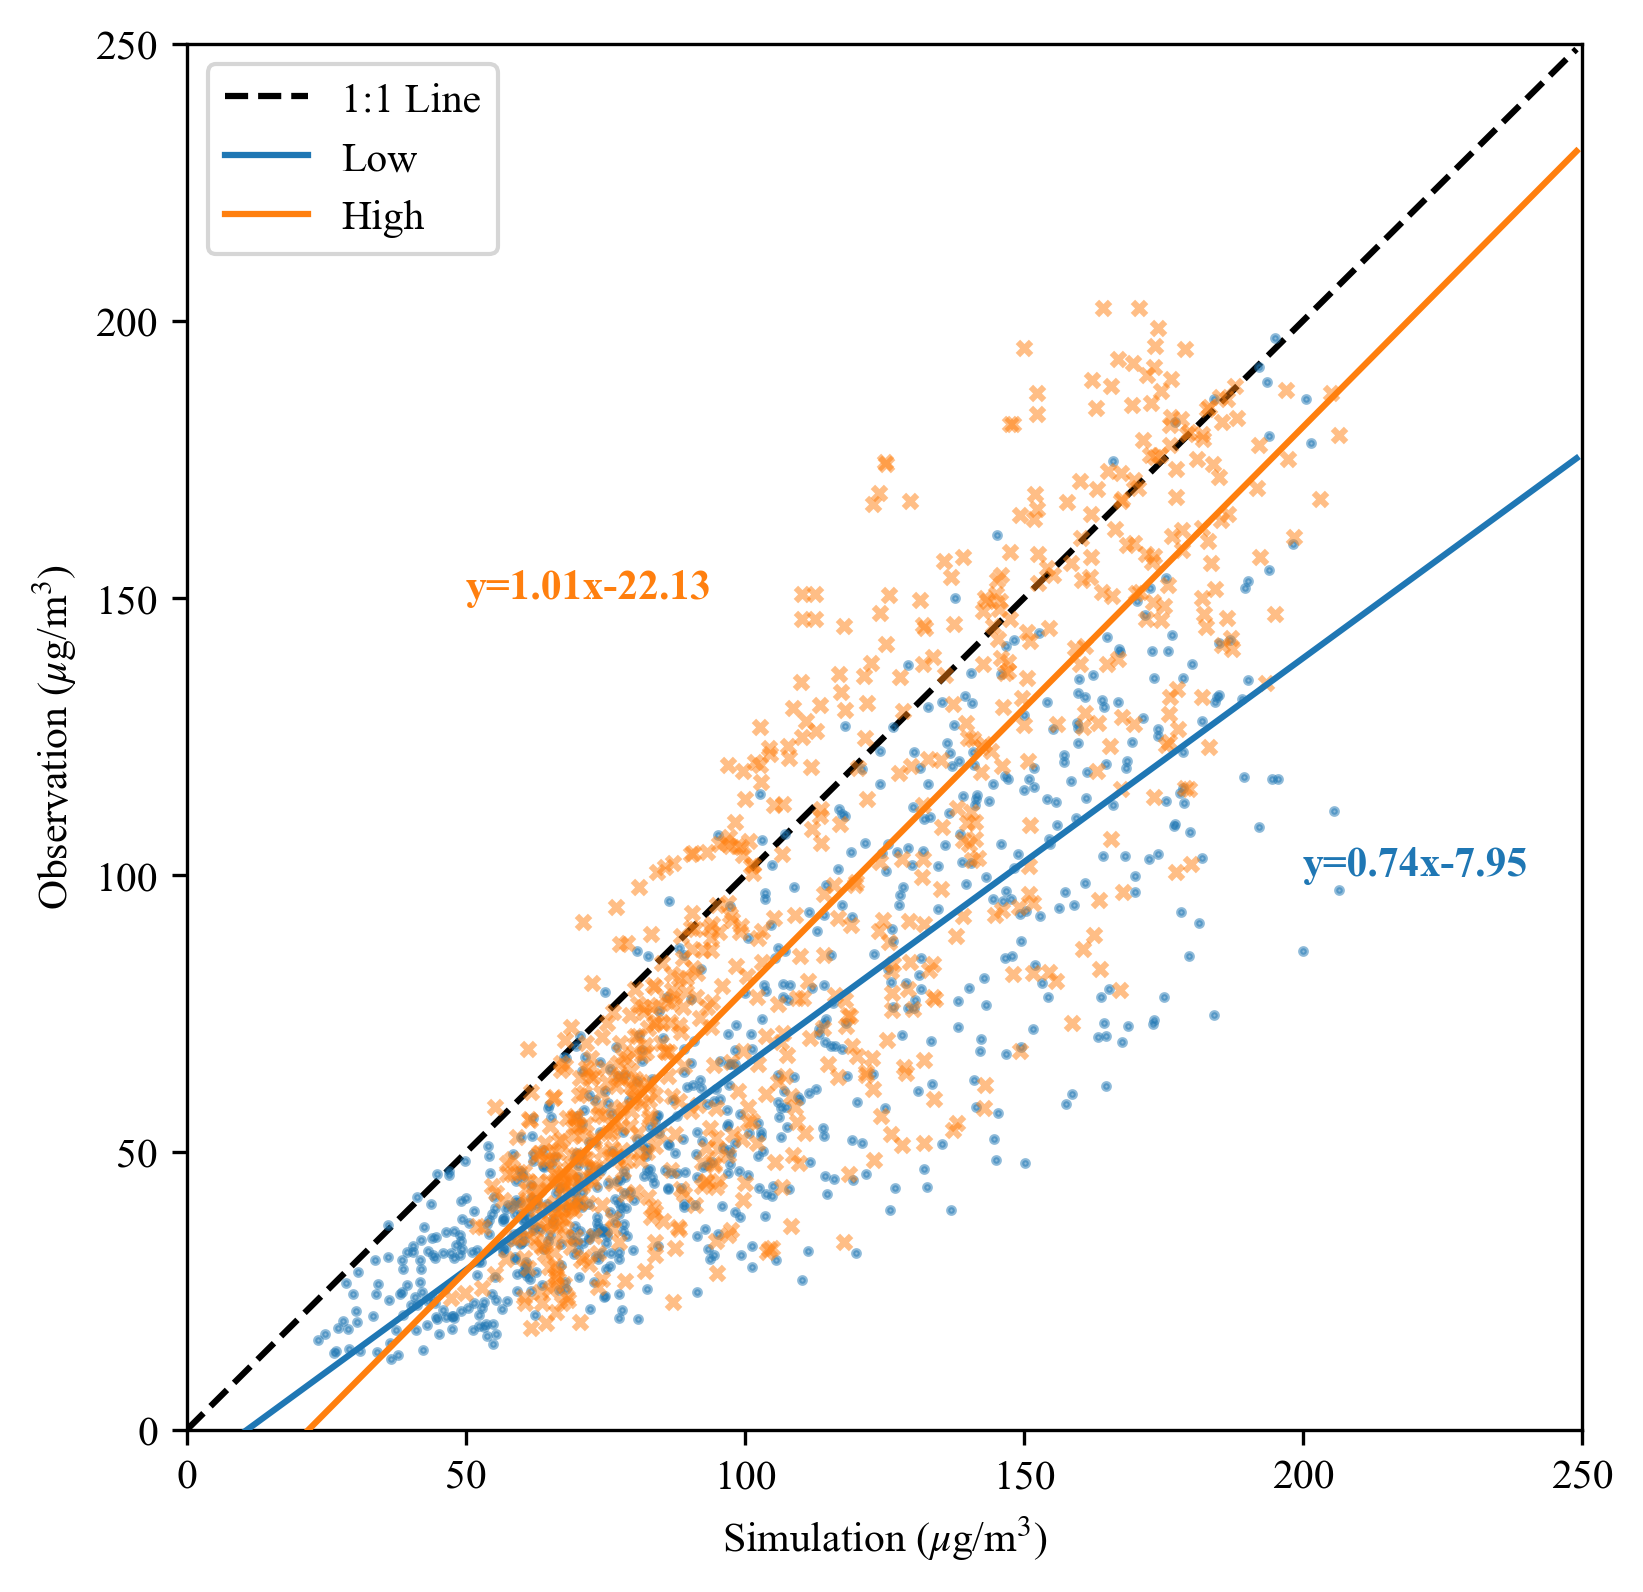

In [81]:
strdict = {'weight':'bold'}

fig = plt.figure(figsize=(6, 6),dpi=300)
ax = fig.add_subplot(111)
ax.plot(np.arange(0,250),np.arange(0,250),'k--',zorder=0,label='1:1 Line')
slope = lr['low']['slope']
intercept = lr['low']['intercept']
ax.plot(np.arange(0,250),slope*np.arange(0,250)+intercept,color='tab:blue',zorder=4,label='Low')
ax.text(200,100,s=f'y={slope:.2f}x{intercept:.2f}',color='tab:blue',fontdict=strdict)
slope = lr['high']['slope']
intercept = lr['high']['intercept']
ax.plot(np.arange(0,250),slope*np.arange(0,250)+intercept,color='tab:orange',zorder=4,label='High')
ax.text(50,150,s=f'y={slope:.2f}x{intercept:.2f}',color='tab:orange',fontdict=strdict)

ax.scatter(results['sim_low'].values, results['obs_low'].values,color='tab:blue',s=10, marker='.',alpha=0.5)
ax.scatter(results['sim_high'].values, results['obs_high'].values,color='tab:orange',s=10, marker='x',alpha=0.5)
ax.set_xlim(0,250)
ax.set_ylim(0,250)
ax.set_xlabel('Simulation ($\mu$g/m$^3$)')
ax.set_ylabel('Observation ($\mu$g/m$^3$)')
ax.legend()
plt.show()

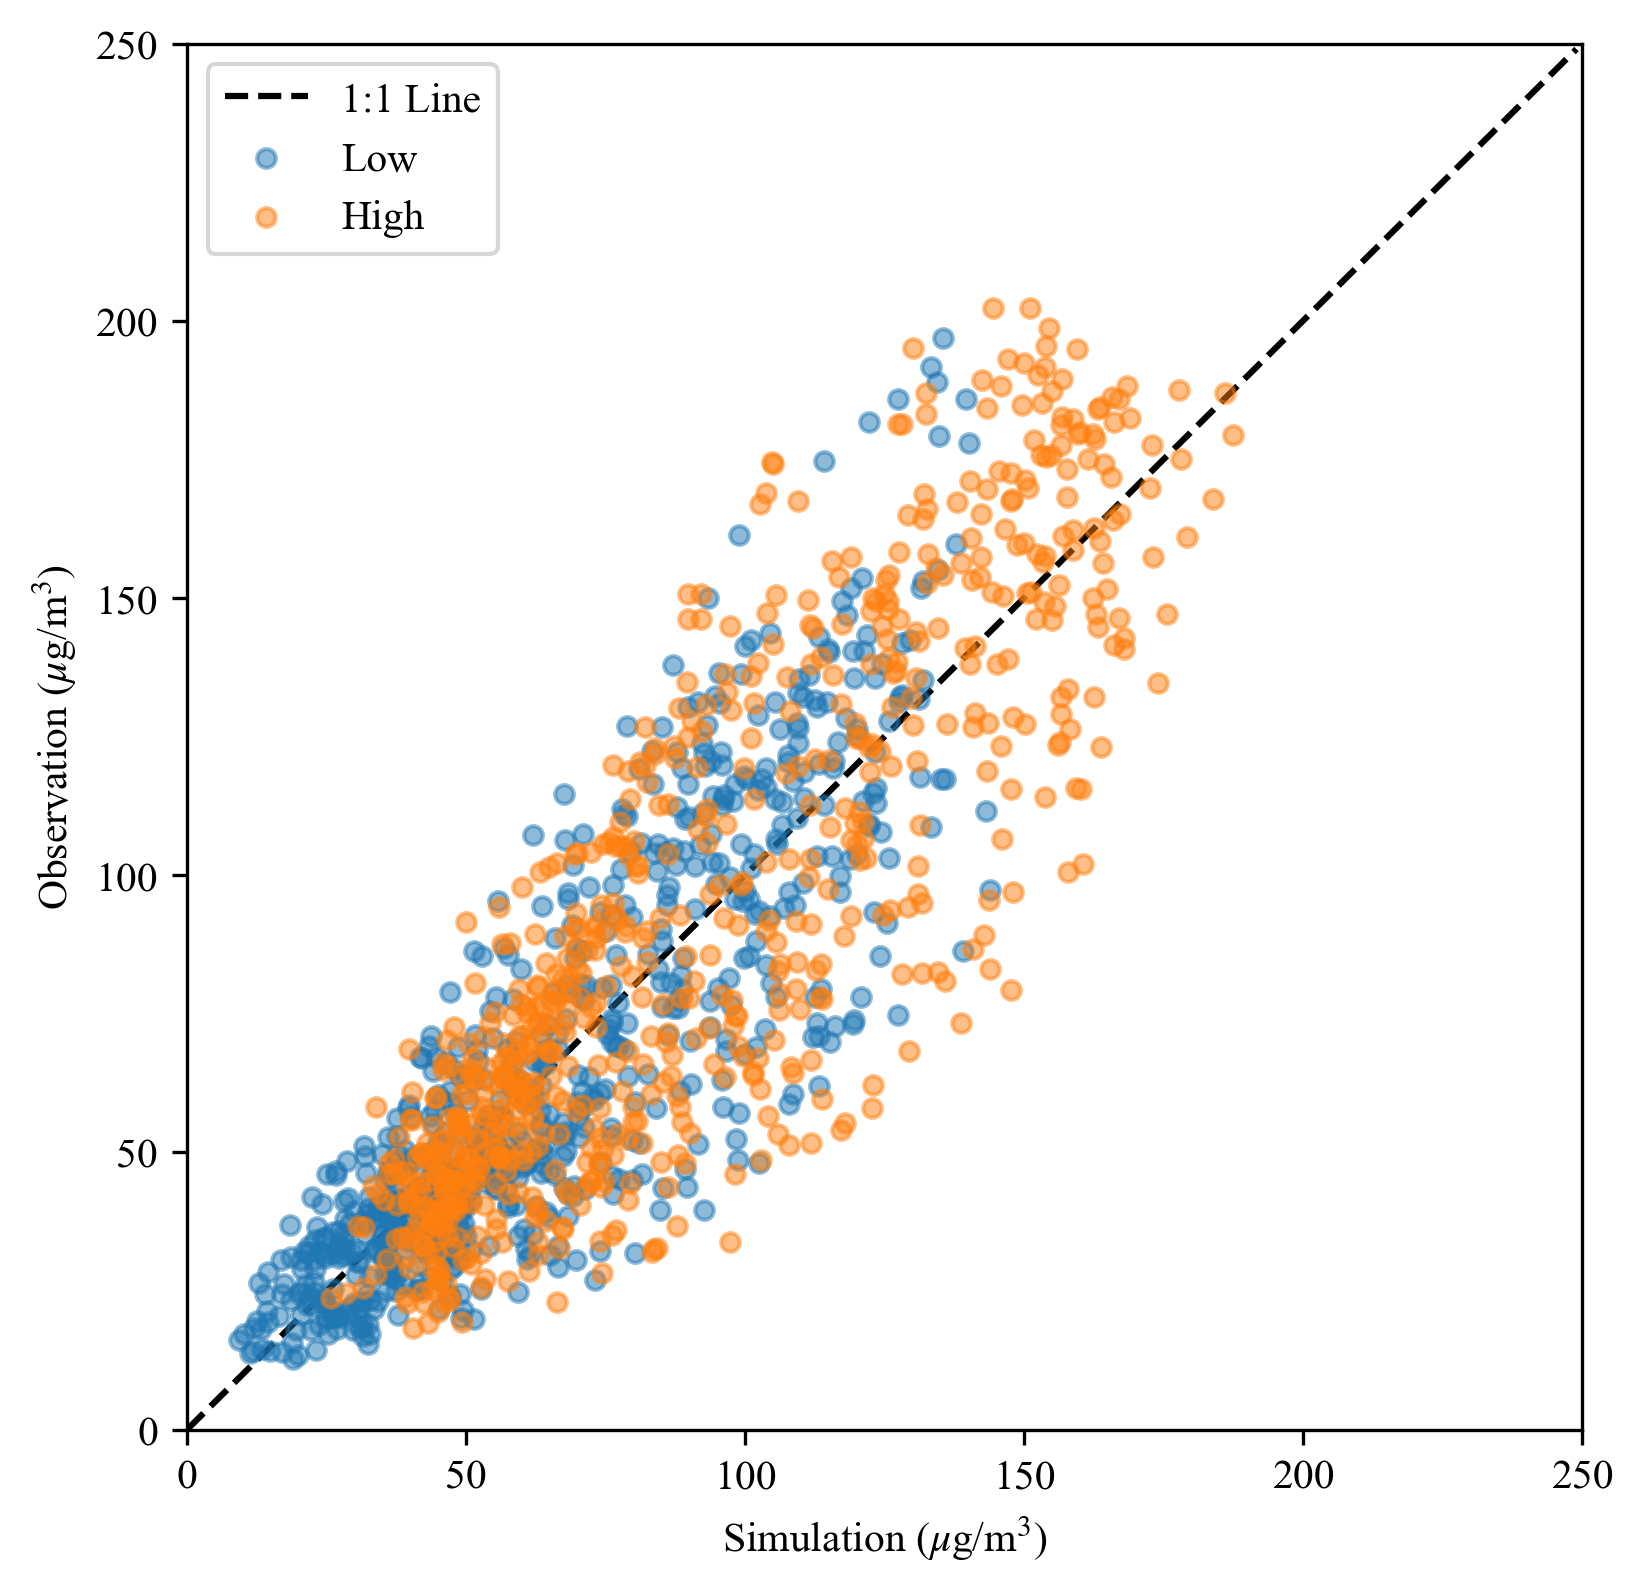

In [86]:
fig = plt.figure(figsize=(6, 6),dpi=300)
ax = fig.add_subplot(111)
ax.plot(np.arange(0,250),np.arange(0,250),'k--',zorder=0,label='1:1 Line')
slope = lr['low']['slope']
intercept = lr['low']['intercept']
ax.scatter(slope*results['sim_low'].values+intercept, results['obs_low'].values,label='Low',color='tab:blue',s=20, marker='o',alpha=0.5)

slope = lr['high']['slope']
intercept = lr['high']['intercept']
ax.scatter(slope*results['sim_high'].values+intercept, results['obs_high'].values,label='High',color='tab:orange',s=20, marker='o',alpha=0.5)
ax.set_xlim(0,250)
ax.set_ylim(0,250)
ax.set_xlabel('Simulation ($\mu$g/m$^3$)')
ax.set_ylabel('Observation ($\mu$g/m$^3$)')
ax.legend()
plt.show()

如果sen用high的回归呢，结果会不太好

In [70]:
delta_obs           = obs_high - obs_low
delta_low_with_sen  = sen_high_lr_high - sim_low_lr_low
delta_high_with_sen = sim_high_lr_high - sen_high_lr_high

print('ΔMET + ΔEMIS = {:.2f}'.format(delta_obs),
      '\nΔMET = {:.2f}'.format(delta_low_with_sen),', {:.2f}%'.format(delta_low_with_sen/delta_obs*100),
      '\nΔEMIS = {:.2f}'.format(delta_high_with_sen),', {:.2f}%'.format(delta_high_with_sen/delta_obs*100))

ΔMET + ΔEMIS = 36.40 
ΔMET = 40.73 , 111.87% 
ΔEMIS = -5.83 , -16.02%


### 输出计算的结果

In [95]:
dfout = pd.DataFrame(
    index=['obs_low','obs_high','sim_low','sim_high','sen_high'],
    columns=['original','lr_by_low','lr_by_high',],
)

dfout['original'] = [obs_low,obs_high,sim_low,sim_high,sen_high]
dfout['lr_by_low'] = [obs_low_lr_low,obs_high_lr_low,sim_low_lr_low,sim_high_lr_low,sen_high_lr_low]
dfout['lr_by_high'] = [obs_low_lr_high,obs_high_lr_high,sim_low_lr_high,sim_high_lr_high,sen_high_lr_high]
dfout

,original,lr_by_low,lr_by_high
obs_low,110.568835,73.373645,90.091582
obs_high,146.973477,100.148610,127.039030
sim_low,153.046076,104.614899,133.202174
sim_high,159.261713,109.186389,139.510488
sen_high,165.006398,113.411503,145.340828


In [96]:
dfout.to_excel('D:/data/Graduation/Contribution/lr_results.xlsx',index=True)